In [1]:
"""
Two-Body System Analysis
Investigating the central mass in Omega Centauri
"""

'\nTwo-Body System Analysis\nInvestigating the central mass in Omega Centauri\n'

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import pyasl
import two_body_utils as utils
import astropy.units as u
import astropy.constants as const
import pandas as pd
from astropy.table import Table
from datetime import datetime


In [3]:
# """
# #Single Orbital Plot
# """

# # Get a sample period in seconds
# per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# #Calculate a single orbit -- No units in arguments
# kes = pyasl.KeplerEllipse(a = utils.semi_major_sample.value, per= per_sample.value, e = utils.e[0], Omega= utils.Omega, 
#                              i= utils.i, w=utils.w)

# # Get a time axis
# # No units in arguments
# # np.linspace(start,stop,num)
# t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# # Calculate the orbit position at the given points in a Cartesian coordinate system.
# pos = kes.xyzPos(t)

# # Calculate the orbit radius 
# radius = kes.radius(t)

# # Calculate velocity on orbit
# vel = kes.xyzVel(t)

# # Find the nodes of the orbit (Observer at -z)
# ascn, descn = kes.xyzNodes_LOSZ()
# # Plot x and y coordinates of the orbit
# plt.subplot(2, 1, 1)
# plt.title("Periapsis (red diamond), Asc. node (green circle), desc. node (red circle)")
# plt.xlabel("East ->")
# plt.ylabel("North ->")
# plt.plot([0], [0], 'k+', markersize=9)
# plt.plot(pos[::, 1], pos[::, 0], 'bp')
# # Point of periapsis
# plt.plot([pos[0, 1]], [pos[0, 0]], 'rd')
# # Nodes of the orbit
# plt.plot([ascn[1]], [ascn[0]], 'go', markersize=10)
# plt.plot([descn[1]], [descn[0]], 'ro', markersize=10)

In [4]:

# """
# #Single Binary Orbit Plots
# """


# # Get a sample period in seconds
# per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# # Calculate a single binary orbit
# # no units in arguments 
# bo = pyasl.BinaryOrbit(utils.m2m1, utils.mtot, per_sample.value, utils.e[0], 
#                        utils.tau, utils.Omega, utils.w, utils.i)

# # Get a time axis
# # No units in arguments!
# # np.linspace(start,stop,num)
# t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# # Calculate primary and secondary orbit
# ke1 = bo.getKeplerEllipse_primary()
# ke2 = bo.getKeplerEllipse_secondary()

# # velocities and radii of single orbit
# r1s, r2s = bo.xyzPos(t)
# v1s, v2s = bo.xyzVel(t)

# # Relative distance of masses (centers) of single orbit
# rds = np.sqrt(np.sum((r1s-r2s)**2, axis=1))

# #Plot binary orbit
# plt.subplot(2,1,1)
# plt.plot(r1s[::,0], r1s[::,1], 'b.-', label="Primary orbit")
# plt.plot(r2s[::,0], r2s[::,1], 'r.-', label="Secondary orbit")
# plt.xlabel("x [m]")
# plt.ylabel("y [m]")
# plt.legend()
# plt.show()
# print()
# print()

# #Plot relative distances
# plt.subplot(2,1,2)
# plt.plot(t/86400, rds, 'b.-', label="Relative distance")
# plt.axvline(utils.tau, ls=':', c='k', label="Time of periastron")
# plt.xlabel("Time [days]")
# plt.ylabel("Relative Distance [m]")
# plt.legend()
# plt.show()
# print()
# print()

# # plot x-velocity
# plt.subplot(3,1,1)
# plt.plot(t/86400, v1s[::,0]/1e3, 'b.-', label="Primary")
# plt.plot(t/86400, v2s[::,0]/1e3, 'r.-', label="Secondary")
# plt.xlabel("Time [days]")
# plt.ylabel("vx [km/s]")
# plt.legend()
# plt.show()
# print()

# # plot y-velocity
# plt.subplot(3,1,2)
# plt.plot(t/86400, v1s[::,1]/1e3, 'b.-', label="Primary")
# plt.plot(t/86400, v2s[::,1]/1e3, 'r.-', label="Secondary")
# plt.xlabel("Time [days]")
# plt.ylabel("vy [km/s]")
# plt.legend()
# plt.show()
# print()

# # plot orbit velocities
# plt.subplot(3,1,3)
# ov1s = np.sqrt(np.sum(v1s**2, axis=1))
# ov2s = np.sqrt(np.sum(v2s**2, axis=1))
# plt.plot(t/86400, ov1s/1e3, 'b.-', label="Primary")
# plt.plot(t/86400, ov2s/1e3, 'r.-', label="Secondary")
# plt.xlabel("Time [days]")
# plt.ylabel("XYZ Orbit velocity [km/s]")
# plt.legend()
# plt.show()


In [5]:
"""
Binary System Calculations
"""
# eccentricities 
# 100 random eccentricities from the thermal distribution 
# The CDF (F(e)) gives probability
# The inverse CDF turns uniform random samples into samples that match probability density
# f(e) = 2e, so more eccentric orbits are more likely than circular
# u=F(e)=e, each proability value is equally likely and maps to some value of e 
p = np.random.uniform(0, 1, utils.n_int)
ecc_distribution = np.sqrt(p)

#Solver for Kepler's equation
# Solves Kepler's Equation for a set
# of mean anomaly and eccentricity.
ks = pyasl.MarkleyKESolver()
print("Eccentric anomalies: \n",ks.getE(utils.M, ecc_distribution))

# Get a sample period in seconds
per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# Get a time axis
# No units in arguments
# np.linspace(start,stop,num)
t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# Initialize empty arrays 
# positions = np.zeros((len(utils.e), 3))  
# velocities = np.zeros((len(utils.e), 3))  
# radii = np.zeros((len(utils.e), 3))
positions = np.zeros((len(ecc_distribution), len(t), 3))  
velocities = np.zeros_like(positions)
radii = np.zeros((len(ecc_distribution), len(t)))

# Loop over each eccentricity and timestep and calculate position, velocity, radius
for k, e_val in enumerate(ecc_distribution):
    # Calculate the ellipse for each value of eccentricity --- No units in arguments!
    ke = pyasl.KeplerEllipse(a = utils.semi_major_sample.value, per = per_sample.value, e = e_val, Omega= utils.Omega, 
                             i= utils.i, w=utils.w)

    for j, time in enumerate(t):
        positions[k, j] = ke.xyzPos(time)
        velocities[k, j] = ke.xyzVel(time)
        radii[k, j] = ke.radius(time)
        
print("\nShape of output array: ", positions.shape, "\n")
print("x, y, z for the first and last of the", utils.n_int, "timesteps: \n","First:\n", positions[:,:1, :: ],
     "\nLast:\n", positions[:,:1, :: ])
positions[0,0]

Eccentric anomalies: 
 [1.44567765 1.1226313  1.72541228 1.47859144 1.72760262 0.96385062
 0.93517285 1.50120537 1.1048557  1.05041254]

Shape of output array:  (10, 10, 3) 

x, y, z for the first and last of the 10 timesteps: 
 First:
 [[[-7.05594456e+05  1.12118324e+08  4.64900302e+07]]

 [[-1.38487211e+06  2.20054931e+08  9.12461052e+07]]

 [[-3.02487722e+04  4.80650268e+06  1.99302350e+06]]

 [[-6.33484336e+05  1.00660091e+08  4.17388567e+07]]

 [[-2.42113284e+04  3.84715828e+06  1.59522992e+06]]

 [[-1.74638621e+06  2.77499198e+08  1.15065456e+08]]

 [[-1.81777934e+06  2.88843501e+08  1.19769388e+08]]

 [[-5.83125684e+05  9.26581463e+07  3.84208385e+07]]

 [[-1.42327832e+06  2.26157644e+08  9.37766043e+07]]

 [[-1.54358005e+06  2.45273481e+08  1.01703014e+08]]] 
Last:
 [[[-7.05594456e+05  1.12118324e+08  4.64900302e+07]]

 [[-1.38487211e+06  2.20054931e+08  9.12461052e+07]]

 [[-3.02487722e+04  4.80650268e+06  1.99302350e+06]]

 [[-6.33484336e+05  1.00660091e+08  4.17388567e+07]]


array([-7.05594456e+05,  1.12118324e+08,  4.64900302e+07])

In [6]:
"""
Binary Orbit Calculations
"""
# eccentricities 
# 100 random eccentricities from the thermal distribution 
# The CDF (F(e)) gives probability
# The inverse CDF turns uniform random samples into samples that match probability density
# f(e) = 2e, so more eccentric orbits are more likely than circular
# u=F(e)=e, each proability value is equally likely and maps to some value of e 
p = np.random.uniform(0, 1, utils.n_int)
ecc_distribution = np.sqrt(p)

# Get a sample period in seconds
per_sample = utils.circular_period(semi_major = utils.semi_major_sample, speed = utils.v_xyz_sample) 

# Binary orbit time intervals
# No units in arguments
# Arguments go as start, stop, number of intervals
# Input time in seconds
t = np.linspace(utils.tau, per_sample.value, utils.n_int) * 86400

# Initialize empty arrays 
# Calculate positions and velocities
r1 = np.zeros((len(utils.e), len(t), 3))
r2 = np.zeros((len(utils.e), len(t), 3))
v1 = np.zeros((len(utils.e), len(t), 3))  
v2 = np.zeros((len(utils.e), len(t), 3))  
        
# Loop over each eccentricity and calculate position, velocity, radius, and the nodes of the orbit (Observer at -z)
for k, e_val in enumerate(ecc_distribution):
    # Calculate binary orbit for each value of eccentricity --- No units!
    bo = pyasl.BinaryOrbit(m2m1 = utils.m2m1, mtot = utils.mtot, per = per_sample.value, e = e_val, 
                       tau = utils.tau, Omega = utils.Omega, w = utils.w, i = utils.i)

    for j, time in enumerate(t):
        # Calculate positions and velocities of the two orbits
        r1[k, j],r2[k, j] = bo.xyzPos(time)  
        v1[k, j],v2[k, j]= bo.xyzVel(time)  

#Velocities in XY
v1_xy = np.linalg.norm(v1[:,:, :2], axis=2)                   
v2_xy = np.linalg.norm(v2[:,:, :2], axis=2)
     
# Relative distance of masses (centers) in meters
rd = np.sqrt(np.sum((r1-r2)**2, axis=2))

# Calculate the xy acceleration of the secondary body in km/s^2
a_xy_secondary = utils.xy_orbital_acceleration_secondary(rd=rd)

In [7]:
# Convert seconds back to days if needed
time_days = t / 86400  

# Create a DataFrame from the meshgrid of indices
ecc_idxs, time_idxs = np.meshgrid(np.arange(rd.shape[0]), np.arange(rd.shape[1]), indexing='ij')

# Flatten all arrays
a_xy_secondary_vals = a_xy_secondary.flatten()
ecc_vals = np.array(ecc_distribution)[ecc_idxs.flatten()]
time_vals = time_days[time_idxs.flatten()]
rd_vals = rd.flatten()

# Create the DataFrame
summary_table = pd.DataFrame({
    "Eccentricity": ecc_vals,
    "Timestep (days)": time_vals,
    "Relative Distance (km)": rd_vals/1000, #Convert meters to kilometrs
    "Acceleration of Secondary Body (km/s^2)": a_xy_secondary_vals
})

# Generate a timestamped named file
sample_acc_vel_title = "Sample_Orbital_Acceleration_vs_Velocity_in_xy_"
timestamp_acc_vel = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename_acc_vel = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_vel_title}{timestamp_acc_vel}.png"

summary_table



,Eccentricity,Timestep (days),Relative Distance (km),Acceleration of Secondary Body (km/s^2)
0,0.821869,0.000000e+00,1.146403e+22,7.992665e-30
1,0.821869,2.835519e+06,6.161327e+22,2.767056e-31
2,0.821869,5.671039e+06,9.124410e+22,1.261702e-31
3,0.821869,8.506558e+06,1.083095e+23,8.954329e-32
4,0.821869,1.134208e+07,1.162774e+23,7.769195e-32
...,...,...,...,...
95,0.555443,1.417760e+07,9.920239e+22,1.067388e-31
96,0.555443,1.701312e+07,9.186888e+22,1.244599e-31
97,0.555443,1.984863e+07,7.653677e+22,1.793189e-31
98,0.555443,2.268415e+07,5.206262e+22,3.875381e-31


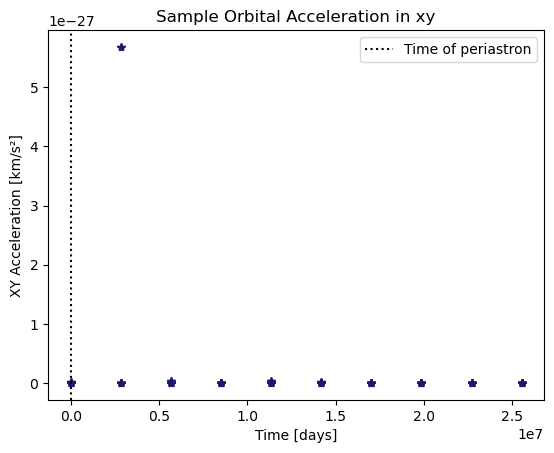

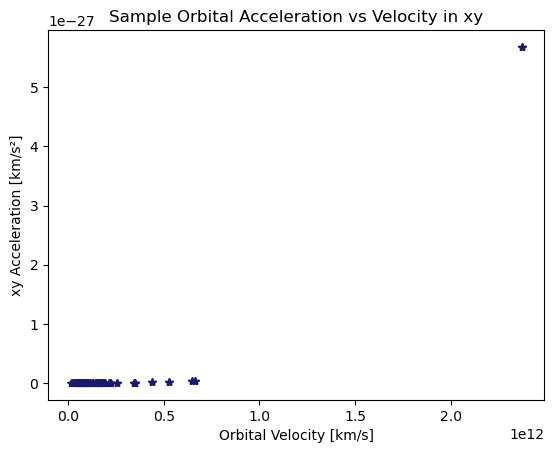

In [36]:
"""
Acceleration Plots of the Secondary Body
"""
# Plot xy orbital acceleration vs time of the secondary body 
plt.plot(t / 86400, a_xy_secondary, '*', color = "midnightblue")
plt.xlabel("Time [days]")
plt.ylabel("XY Acceleration [km/s²]")
plt.title("Sample Orbital Acceleration in xy")
plt.axvline(utils.tau, ls=':', c='k', label="Time of periastron")
plt.legend()

# Generate a timestamped named file
sample_acc_title = "Sample_Orbital_Acceleration_in_xy_"
timestamp_acc = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename_acc = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_title}{timestamp_acc}.png"

# Save and show the plot
#plt.savefig(filename_acc)
plt.show()

# Plot xy orbital acceleration vs xy orbital velocity of the secondary body 
plt.plot( v2_xy/1e3, a_xy_secondary, '*', color = "midnightblue")
plt.xlabel("Orbital Velocity [km/s]")
plt.ylabel("xy Acceleration [km/s²]")
plt.title("Sample Orbital Acceleration vs Velocity in xy")

# Generate a timestamped named file
sample_acc_vel_title = "Sample_Orbital_Acceleration_vs_Velocity_in_xy_"
timestamp_acc_vel = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename_acc_vel = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_vel_title}{timestamp_acc_vel}.png"

# Save and show the plot
#plt.savefig(filename_acc_vel)
plt.show()

In [9]:
"""
Observed 2D Velocities and Accelerations 
From high-velocity stars in Omega Centauri
"""

# 2d velocities:
# Measured v2D A: (113.0±1.1) km s−1 B: (66.6±4.1) km s−1 C: (94.9±1.7) km s−1 D: (77.9±2.0) km s−1 E: (69.6±0.8) km s−1 F: (67.4±0.4) km s−1 G: (66.2±1.9) km s−1
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2])*u.km/u.s
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9])*u.km/u.s

# Acceleration R.A. [mas/yr^2] -0.0069±0.0083 (0.8σ) 0.0702±0.0239 (2.9σ) 0.0028±0.0333 (0.1σ) 0.0357±0.0177 (2.0σ) 0.0072±0.0042 (1.7σ) 0.0052±0.0038 (1.4σ)  -0.0197±0.0267 (0.7σ)
a_ra = (np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]))*u.mas/u.yr**2
a_ra_err = (np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267])) *u.mas/u.yr**2

# Acceleration Dec. [mas/yr^2] 0.0085±0.0098 (0.9σ) 0.0228±0.0157 (1.5σ) -0.0060±0.0123 (0.5σ) -0.0194±0.0162 (1.2σ) -0.0009±0.0075 (0.1σ) -0.0015±0.0038 (0.4σ) 0.0173±0.0170 (1.0σ)
a_dec = (np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]))*u.mas/u.yr**2
a_dec_err = (np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170]))*u.mas/u.yr**2

# Acceleration in the plane of the sky [km/s^2]
#a_total = utils.masyr2_to_kms2((np.sqrt(a_ra**2 + a_dec**2)), distance_km = 1*u.km)
#a_total_err = utils.masyr2_to_kms2((np.sqrt((a_ra * a_ra_err / a_total)**2 + (a_dec * a_dec_err / a_total)**2)), distance_km = 1*u.km)

# Total angular acceleration and in mas/yr²
a_total_masyr2 = np.sqrt(a_ra**2 + a_dec**2)

# Propagate error in mas/yr²
a_total_masyr2_err = np.sqrt((a_ra * a_ra_err / a_total_masyr2)**2 + (a_dec * a_dec_err / a_total_masyr2)**2)

# Conversion to km/s²
a_total = utils.masyr2_to_kms2(a_masyr2 = a_total_masyr2, distance_km = utils.distance_km)
a_total_err = utils.masyr2_to_kms2(a_masyr2 = a_total_masyr2_err, distance_km = utils.distance_km)


In [10]:
"""
Data Table for Omega Centauri Stars
"""
star_data = Table(
    {
        "v2D": v2D,
        "v2D_err": v2D_err,
        "a_ra": a_ra,
        "a_ra_err": a_ra_err,
        "a_dec": a_dec,
        "a_dec_err": a_dec_err,
        "a_total": a_total,
        "a_total_err": a_total_err,
    }
)
star_data

v2D,v2D_err,a_ra,a_ra_err,a_dec,a_dec_err,a_total,a_total_err
km / s,km / s,mas / yr2,mas / yr2,mas / yr2,mas / yr2,km / s2,km / s2
float64,float64,float64,float64,float64,float64,float64,float64
113.0,1.1,-0.0069,0.0083,0.0085,0.0098,8.930061383293236e-09,7.531455373299496e-09
66.6,4.1,0.0702,0.0239,0.0228,0.0157,6.02047938832453e-08,1.8958529783912896e-08
94.9,1.7,0.0028,0.0333,-0.006,0.0123,5.400731419743836e-09,1.4649029465648002e-08
77.9,2.0,0.0357,0.0177,-0.0194,0.0162,3.314142014778814e-08,1.4167818247443028e-08
69.6,0.8,0.0072,0.0042,-0.0009,0.0075,5.918566003817241e-09,3.483038561817065e-09
67.4,0.4,0.0052,0.0038,-0.0015,0.0038,4.4144539757184885e-09,3.0995661122692196e-09
66.2,1.9,-0.0197,0.0267,0.0173,0.017,2.1385320005943142e-08,1.8748565257835362e-08


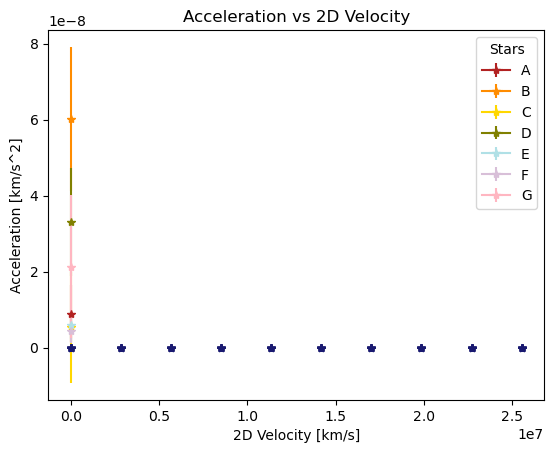

In [38]:
"""
Plot of Accelleration vs 2D Velocities of Omega Centauri Stars
"""
# Plot acceleration [km/s^2] vs 2D velocities [km/s]
plt.xlabel("2D Velocity [km/s]")
plt.ylabel("Acceleration [km/s^2]")
plt.title("Acceleration vs 2D Velocity")
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i],
        y=a_total[i],
        yerr=a_total_err[i],
        xerr =v2D_err[i],
        marker="*",
        label=labels[i],
        color=colours[i],
    )
plt.plot(t / 86400, a_xy_secondary, '*', color = "midnightblue")
plt.legend(title='Stars')


# Generate timestamped named file
plot_name = "Acceleration_vs_2D_Velocity "
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{plot_name}{timestamp}.png"

# Save and show the plot
# plt.savefig(filename)
plt.show()

In [12]:
"""
Using some functions
"""
e = utils.e
E = utils.eccentric_annomaly(e = e)
nu = utils.true_anomaly(E = E, e = e)
r = utils.relative_distance(e = e, nu = nu)
a2_xy = utils.xy_orbital_acceleration_secondary(rd=r)

